# Histogram Equalization
## What is histogram equalization?
Histogram Equalization is an image processing method to adjust the contrast of an image using it's intensity histogram. 

Histogram equalization is a technique for adjusting image intensities to enhance contrast.

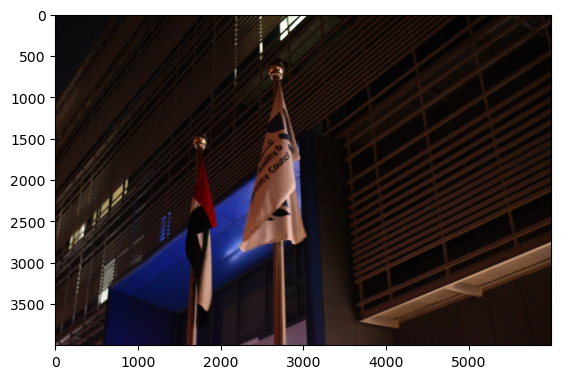

(4000, 6000, 3)

In [194]:
import matplotlib.pyplot as plt 
import cv2 

# img = cv2.imread('data/DSC_0185.JPG')
# img = cv2.imread('data/DSC_0214.JPG')
# img = cv2.imread('data/DSC_0253.JPG')
img = cv2.imread('data/DSC_0232.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
img.shape

## Plotting the pixel intensities

In [195]:
import numpy as np

np.max(img), np.min(img)

(255, 0)

## Plotting the Histogram of the RGB Channels

In [196]:
red_channel_img   = img[:, :, 0]
green_channel_img = img[:, :, 1]
blue_channel_img  = img[:, :, 2]

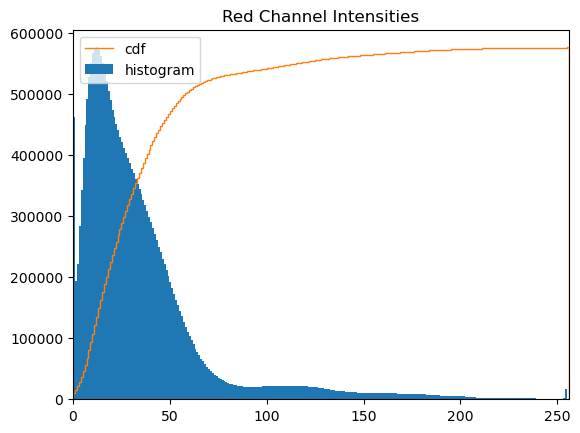

In [197]:
def plot_histogram(channel_intensities:np.ndarray, title:str):
    hist, bins = np.histogram(channel_intensities.ravel(), bins=256, range=(0,256))
    cdf = hist.cumsum()
    cdf_norm = cdf * float(hist.max()) / cdf.max()


    plt.hist(channel_intensities.ravel(), bins=256, range=(0,255))
    plt.stairs(cdf_norm)
    plt.title(title)
    plt.xlim([0, 256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()

plot_histogram(red_channel_img, 'Red Channel Intensities')

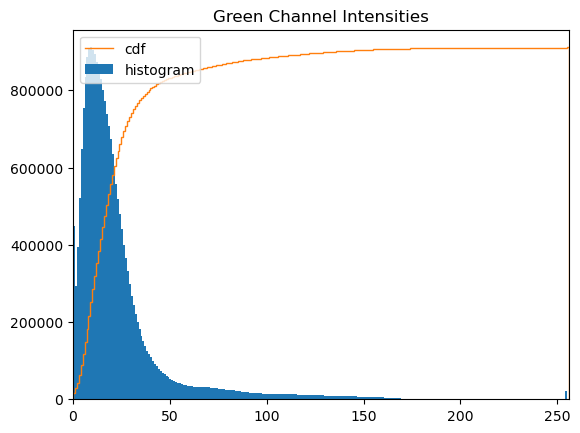

In [198]:
plot_histogram(green_channel_img, 'Green Channel Intensities')

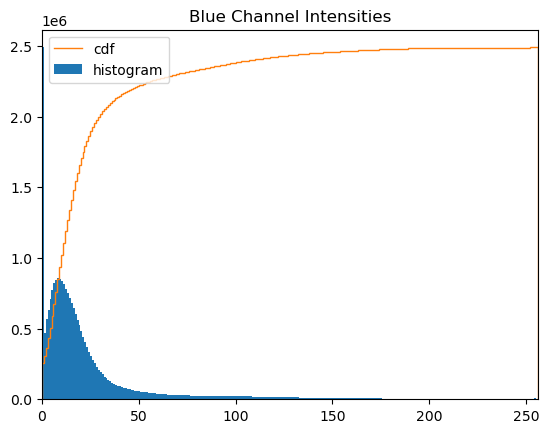

In [199]:
plot_histogram(blue_channel_img, 'Blue Channel Intensities')

In [200]:
def calc_cdf(count):
    # pdf = count / sum(count)
    # pdf = count # TODO: Uncomment the above line when done debuging
    cdf = np.cumsum(count) / sum(count)
    # cdf = cdf / sum(count)
    return cdf

def histogram_equalization(image:np.ndarray, nbins=255):
    hist, bin_centers = np.histogram(image.ravel(), bins=nbins)
    # bin_width = bin_centers[1] - bin_centers[0]
    cdf = calc_cdf(hist)

    flattened_img = image.ravel()
    out = []
    for pix in flattened_img:
        out.append(cdf[pix-1])

    out = (np.array(out).reshape(image.shape) * 255).astype('uint8')
    return out 
    # TODO: Map each pixel to corresponding histogram intensity
    
    # return hist, bin_centers, cdf
    # cdf, bin_centers = cumulative_distribution(image, nbins)
    # out = np.interp(image.flat, bin_centers, cdf)
    # out = out.reshape(image.shape)
    # # Unfortunately, np.interp currently always promotes to float64, so we
    # # have to cast back to single precision when float32 output is desired
    # return out.astype(utils._supported_float_type(image.dtype), copy=False)

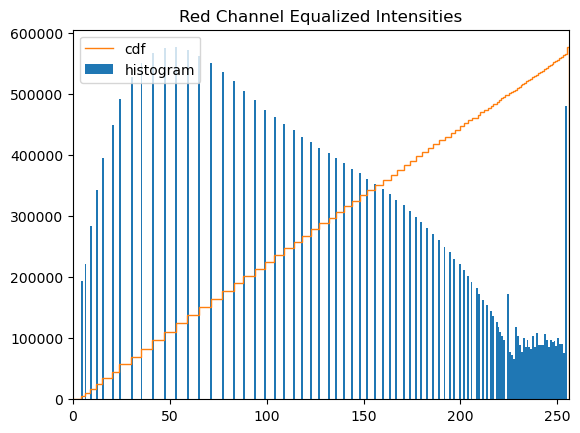

In [201]:


red_equalized_channel = histogram_equalization(red_channel_img)
plot_histogram(red_equalized_channel, 'Red Channel Equalized Intensities')

# red_cdf = calc_cdf(red_channel_img.ravel())
# norm_red_cdf = red_cdf * np.max(red_equalized_channel) / red_cdf.max()


# plt.plot(norm_red_cdf)
# plt.hist(red_equalized_channel.ravel(), bins=256, range=(0,255))
# plt.hist(red_equalized_channel.ravel(), bins=256, range=(0,255), density=True)
# plt.show()
# red_equalized_channel.max()

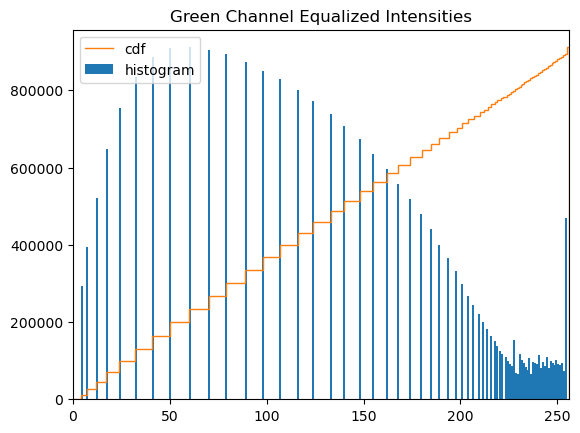

In [202]:
green_equalized_channel = histogram_equalization(green_channel_img)
plot_histogram(green_equalized_channel, 'Green Channel Equalized Intensities')

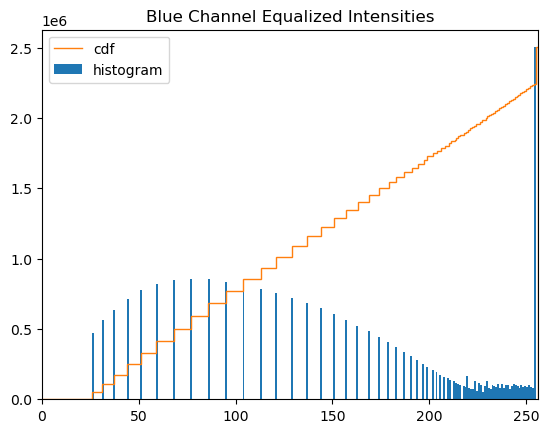

In [203]:
blue_equalized_channel = histogram_equalization(blue_channel_img)
plot_histogram(blue_equalized_channel, 'Blue Channel Equalized Intensities')

In [204]:

out = np.zeros(img.shape, dtype='uint8')
out[:, :, 0] = red_equalized_channel
out[:, :, 1] = green_equalized_channel
out[:, :, 2] = blue_equalized_channel


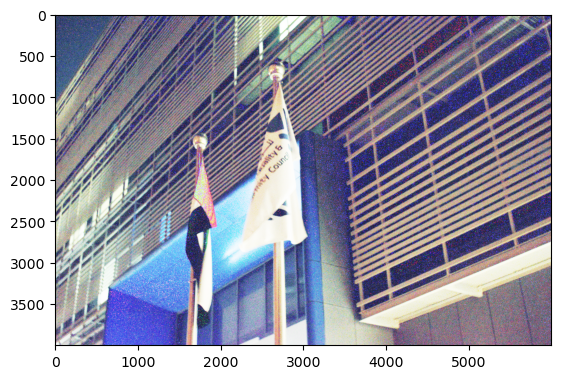

In [205]:
plt.imshow(out)

# Comparison with cv2 function

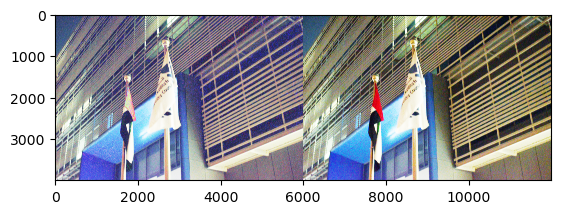

In [206]:
def equalize_histogram_cv(img:np.ndarray):
    out = np.zeros(img.shape, dtype='uint8')
    for i in range(3):
        out[:, :, i] = cv2.equalizeHist(img[:, :, i])

    return out


# equ = cv2.equalizeHist(cv2.imread('The_dress_blueblackwhitegold.jpg', cv2.IMREAD_GRAYSCALE))
# equ = cv2.equalizeHist(green_channel_img)
cv2_result = equalize_histogram_cv(img)

# equ = equalize_histogram_cv(img)
res = np.hstack((out,cv2_result))
plt.imshow(res)
plt.show()


In [207]:
from math import log10, sqrt 

def mean_squared_error(x1, x2):
    return np.mean(np.square(x1 - x2))


def psnr(x1, x2): 
    mse = mean_squared_error(x1, x2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 


print(f'Mean Square Error: {mean_squared_error(out, cv2_result):.2f}')
print(f'PSNR: {psnr(out, cv2_result):.2f} db')


Mean Square Error: 23.62
PSNR: 34.40 db
